### Retrieve historical and projected tasmin from NEX-GDDP-CMIP6 for existing orchards.

using 10 years of data to start out

In [1]:
import sys 
import os
import s3fs

rel_path = "../src"
directory_path = os.path.abspath(os.path.join(os.getcwd(), rel_path))
sys.path.append(directory_path)

from nex_gddp_cmip6 import get_nex_dataset, TIME_OPTIMIZED_SCENARIOS, AVAILABLE_VARIABLES, load_region, select_region

import xarray as xr
import pandas as pd
import numpy as np

import geopandas as gpd

import matplotlib.pyplot as plt

import dask
from dask.distributed import Client

In [4]:
# Initiate Dask Cluster

endpoint = "tcp://127.0.0.1:59591"

if endpoint:
    client = Client(endpoint)

else:
    client = Client()

client

<Client: 'tcp://127.0.0.1:59591' processes=4 threads=12, memory=31.92 GiB>

In [5]:
# starting region
orchards_shape_file_path = "../data/processed/gdf_easternmountain_polygons/gdf_easternmountain_polygons.shp"

east_orchards_gdf = gpd.read_file(orchards_shape_file_path)
east_orchards_gdf.geometry = east_orchards_gdf.geometry.translate(xoff=-180) 

In [6]:
#https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
states = gpd.read_file('../data/external/cb_2018_us_state_5m/cb_2018_us_state_5m.shp')
states = states.to_crs("EPSG:4326") 

#northwest = states[states['STUSPS'].isin(['PA','NY','VA','MD','CT', 'MA', 'DE', 'NJ','WV','NH','VT','ME'])]
east = states[states['STUSPS'].isin(['VA','NC','WV','MD','PA'])]

Text(48.338895912556296, 0.5, 'Latitude [Degrees North]')

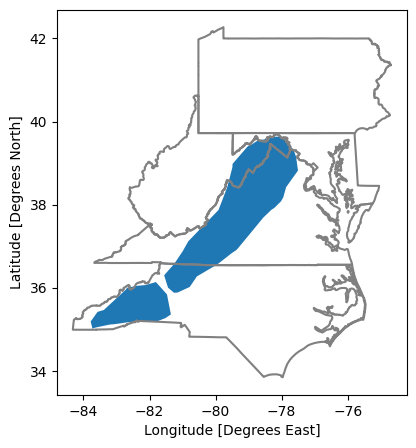

In [7]:
us_boundary_map = east.boundary.plot(figsize=(5, 5), color="Gray")
east_orchards_gdf.plot(ax = us_boundary_map)
plt.xlabel('Longitude [Degrees East]')
plt.ylabel('Latitude [Degrees North]')

In [8]:
# Load Data
ds_historical = get_nex_dataset(AVAILABLE_VARIABLES,["historical"])
ds_projection = get_nex_dataset(AVAILABLE_VARIABLES,["projection"])

In [9]:
ds_historical 

<xarray.Dataset> Size: 15TB
Dimensions:   (model: 20, scenario: 1, time: 23741, lat: 600, lon: 1440)
Coordinates:
  * lat       (lat) float64 5kB -59.88 -59.62 -59.38 ... 89.38 89.62 89.88
  * model     (model) <U10 800B 'ACCESS-CM2' 'ACCESS-ESM' ... 'UKESM1-0-L'
  * scenario  (scenario) <U10 40B 'historical'
  * time      (time) datetime64[ns] 190kB 1950-01-01T12:00:00 ... 2014-12-31T...
  * lon       (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    hurs      (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    huss      (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    pr        (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    rlds      (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    rsds      (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    sfcWind   (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    tas       (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    tasmax    (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    tasmin    (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
Attributes: (12/23)
    Conventions:           CF-1.7
    activity:              NEX-GDDP-CMIP6
    cmip6_institution_id:  CSIRO-ARCCSS
    cmip6_license:         CC-BY 4.0
    cmip6_source_id:       ACCESS-CM2
    contact:               Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget...
    ...                    ...
    source:                BCSD
    title:                 ACCESS-CM2, r1i1p1f1, historical, global downscale...
    tracking_id:           f9f489de-f5f7-43de-8f55-f0c001fad19a
    variant_label:         r1i1p1f1
    version:               1.1
    crs:                   EPSG:4326

In [11]:
ds_historical_clipped = select_region(ds_historical, east_orchards_gdf)
ds_projection_clipped = select_region(ds_projection, east_orchards_gdf)

In [10]:
# sample vis 
#ds_historical['tasmin'].isel(model = 0, time=0).plot()


Retrieve historical and projected tasmin from NEX-GDDP-CMIP6 for existing orchards. 

In [12]:
train_da = ds_projection_clipped['tasmin'].sel(time=slice('2015-01-01T12:00:00.000000000', '2021-12-31T12:00:00.000000000'))
val_da = ds_projection_clipped['tasmin'].sel(time=slice('2022-01-01T12:00:00.000000000', '2022-12-31T12:00:00.000000000'))


# Will use ERA5 for test data
#test_da = ds_projection_clipped['tasmin'].sel(time=slice('2023-01-01T12:00:00.000000000', '2023-12-31T12:00:00.000000000'))

In [13]:
train_da

<xarray.DataArray 'tasmin' (model: 20, scenario: 4, time: 2557, lat: 19, lon: 25)> Size: 389MB
dask.array<getitem, shape=(20, 4, 2557, 19, 25), dtype=float32, chunksize=(8, 4, 2557, 10, 15), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float64 152B 35.12 35.38 35.62 ... 39.12 39.38 39.62
  * model        (model) <U10 800B 'ACCESS-CM2' 'ACCESS-ESM' ... 'UKESM1-0-L'
  * scenario     (scenario) <U6 96B 'ssp126' 'ssp245' 'ssp370' 'ssp585'
  * time         (time) datetime64[ns] 20kB 2015-01-01T12:00:00 ... 2021-12-3...
  * lon          (lon) float64 200B -83.62 -83.38 -83.12 ... -77.88 -77.62
    spatial_ref  int32 4B 0
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: maximum
    comment:        near-surface (usually, 2 meter) minimum air temperature; ...
    long_name:      Daily Near-Surface Minimum Air Temperature
    standard_name:  air_temperature
    units:          K

# Dask Dataframe

Notes: 
- I noticed that when a dask client is running, that parallel computing is performed for the operation.
- might get issues with deserializing, so need to upgrade msgpack to latest version
    - https://github.com/dask/distributed/issues/8038

In [15]:
# https://docs.xarray.dev/en/latest/generated/xarray.DataArray.to_dask_dataframe.html

train_df = train_da.to_dask_dataframe(['lat', 'model', 'scenario', 'time', 'lon'])
val_df = val_da.to_dask_dataframe(['lat', 'model', 'scenario', 'time', 'lon'])

c:\Users\manwi\anaconda3\envs\cap_env\Lib\site-packages\IPython\core\interactiveshell.py:3577: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explicitly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\manwi\anaconda3\envs\cap_env\Lib\site-packages\IPython\core\interactiveshell.py:3577: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avo

In [16]:
# lazy loading, pre-compute:
train_df

,lat,model,scenario,time,lon,spatial_ref,tasmin
npartitions=18,,,,,,,
0,float64,string,string,datetime64[ns],float64,int32,float32
5114000,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
92052000,...,...,...,...,...,...,...
97165999,...,...,...,...,...,...,...


In [ ]:
train_df = train_df.compute()

In [17]:
val_df = val_df.compute()

KilledWorker: Attempted to run task ('repartitiontofewer-c380b34b8e3a8f9ef05b9f6ebfc268a3', 0) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:60693. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [ ]:
train_df = train_df.dropna()
val_df = val_df.dropna()

print(train_df.shape)

In [ ]:
train_df.head(5)

,lat,lon,scenario,time,model,spatial_ref,tasmin
0,41.875,93.375,historical,1950-01-01 12:00:00,ACCESS-CM2,0,258.037994
1,41.875,93.375,historical,1950-01-02 12:00:00,ACCESS-CM2,0,259.913177
2,41.875,93.375,historical,1950-01-03 12:00:00,ACCESS-CM2,0,257.775818
3,41.875,93.375,historical,1950-01-04 12:00:00,ACCESS-CM2,0,256.759705
4,41.875,93.375,historical,1950-01-05 12:00:00,ACCESS-CM2,0,255.912247


In [ ]:
# Export data to disk
region = 'east'
train_df.to_csv(f"../data/train/train_{east}_tasmin_CMIP6_projections.csv")
val_df.to_csv(f"../data/val/val_{east}_tasmin_CMIP6_projections.csv")


Resampling:

In [51]:
# Perform Groupby
# https://examples.dask.org/dataframes/02-groupby.html

train_df_gb = train_df.groupby(train_df['time'].dt.year)['tasmin'].mean()

Text(0.5, 1.0, 'ACCESS-CM2 - tsmin_df ')

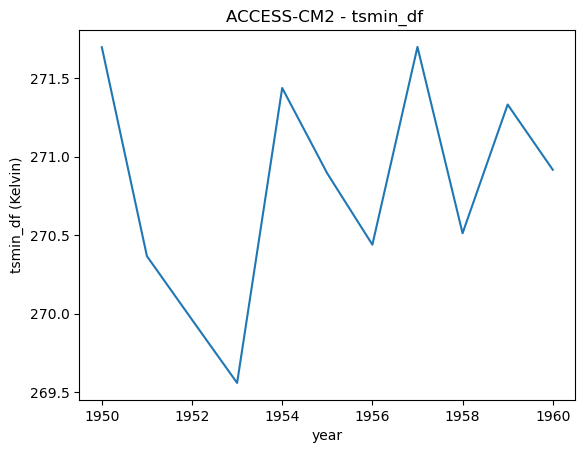

In [53]:
plt.plot(train_df_gb)
plt.xlabel('year')
plt.ylabel('tsmin_df (Kelvin)')
plt.title('ACCESS-CM2 - tsmin_df ')

## Clean-up

In [3]:
# when ready to shutdown cluster
#client.shutdown()